## SINE GENERATION WITH 1D GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from keras.layers import Dense, ReLU
from keras.models import Sequential
from keras.optimizers import Adam

style.use("dark_background")

In [2]:
# define optimizer

adam = Adam(learning_rate=0.0002)

In [3]:
# define macro

LATENT_DIM = 5
SHAPE_OUT = 2

In [4]:
# define generator

def build_generator(latent_dim, shape_out):

    generator = Sequential(name="GENERATOR")

    generator.add(Dense(units=25, input_dim=latent_dim))
    generator.add(ReLU())

    generator.add(Dense(units=shape_out, activation="sigmoid"))

    generator.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

    return generator


In [5]:
generator = build_generator(latent_dim=LATENT_DIM, shape_out=SHAPE_OUT)
generator.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "GENERATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                150       
                                                                 
 re_lu (ReLU)                (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


2022-06-09 00:42:59.043284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 00:42:59.043407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def build_discriminator(input_dim):

    discriminator = Sequential(name="DISCRIMINATOR")
    discriminator.add(Dense(units=25, input_shape=(input_dim, )))
    discriminator.add(ReLU())

    discriminator.add(Dense(units=1, activation="sigmoid"))
    
    discriminator.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

    return discriminator

In [7]:
discriminator = build_discriminator(input_dim=SHAPE_OUT)
discriminator.summary()

Model: "DISCRIMINATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                75        
                                                                 
 re_lu_1 (ReLU)              (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [8]:
# generate real samples

def generate_real_samples(n_samples):

    x = np.random.randn(n_samples)
    y = np.sin(x)
    x = x.reshape(n_samples, 1)
    y = y.reshape(n_samples, 1)
    x_real = np.hstack((x, y))
    y_real = np.ones((n_samples, 1))

    return x_real, y_real

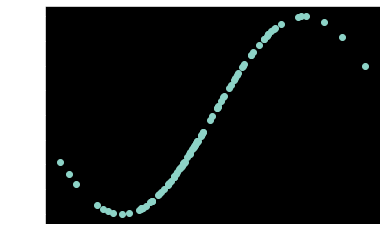

In [9]:
real_x, _ = generate_real_samples(n_samples=100)

plt.scatter(real_x[:, 0], real_x[:, 1])
plt.show()

In [10]:
# generate latent space and fake samples

def generate_latent_dimension(latent_dim, n_samples):

    x = np.random.randn(latent_dim * n_samples)
    x = x.reshape(n_samples, latent_dim)

    return x

def generate_fake_samples(model, latent_dim, n_samples):

    x_fake = generate_latent_dimension(latent_dim=latent_dim, n_samples=n_samples)
    x_fake = model.predict(x_fake, verbose=0)
    y_fake = np.zeros((n_samples, 1))

    return x_fake, y_fake

2022-06-09 00:43:07.298240: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 00:43:07.329240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


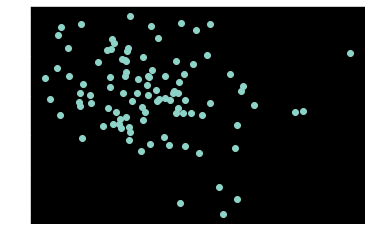

In [11]:
x_fake, _ = generate_fake_samples(model=generator, latent_dim=LATENT_DIM, n_samples=100)

plt.scatter(x_fake[:, 0], x_fake[:, 1])
plt.show()

In [12]:
# define GAN

def build_gan(generator, discriminator):
    discriminator.trainable = False

    gan = Sequential(name="COMBINED_MODEL")
    gan.add(generator)
    gan.add(discriminator)

    gan.compile(loss="binary_crossentropy", optimizer=adam)

    return gan

In [13]:
gan = build_gan(generator=generator, discriminator=discriminator)
gan.summary()

Model: "COMBINED_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GENERATOR (Sequential)      (None, 2)                 202       
                                                                 
 DISCRIMINATOR (Sequential)  (None, 1)                 101       
                                                                 
Total params: 303
Trainable params: 202
Non-trainable params: 101
_________________________________________________________________


In [14]:
# summary of performace

def summarize(generator, discriminator, latent_dim, n_samples, epoch):

    x_real, y_real = generate_real_samples(n_samples=n_samples)
    x_fake, y_fake = generate_fake_samples(model=generator, latent_dim=latent_dim, n_samples=n_samples)

    loss_real, acc_real = discriminator.evaluate(x_real, y_real)
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake)

    print(f"EPOCH [{epoch + 1}]\tACCURACY REAL [{acc_real}]\tACCURACY FAKE [{acc_fake}]")

    plt.scatter(x_real[:, 0], x_real[:, 1], color="r")
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color="y")
    plt.show()


In [15]:
# train model

def train_model(epochs, generator, discriminator, gan, latent_dim, batch_size):
    
    half_batch = batch_size//2

    for epoch in range(epochs):

        # generate real samples and train discriminator
        discriminator.trainable = True
        x_real, y_real = generate_real_samples(n_samples=half_batch)
        x_fake, y_fake = generate_fake_samples(model=generator, latent_dim=latent_dim, n_samples=half_batch)

        discriminator.train_on_batch(x_real, y_real)
        discriminator.train_on_batch(x_fake, y_fake)

        # train gan
        discriminator.trainable = False
        x_gan = generate_latent_dimension(latent_dim=latent_dim, n_samples=batch_size)
        y_gan = np.ones((batch_size, 1))

        gan.train_on_batch(x_gan, y_gan)

        if epoch%100 == 0:
            summarize(generator, discriminator, latent_dim, 100, epoch)



In [ ]:
epochs = 1000
batch_size = 128

train_model(

    epochs=epochs, 
    generator=generator,
    discriminator=discriminator,
    gan=gan,
    latent_dim=LATENT_DIM,
    batch_size=batch_size

)